# Описание задачи.

Мы – организаторы некой многопользовательской онлайн-игры. На каждого игрока мы ведем игровую статистику, которая представлена <br/>
в виде 127 игровых показателей. Каждый показатель характеризует поведение игрока в одной разновидности игровых ситуаций. <br/>
Показатель является отношением числа произведенных игровых действий одного типа к числу возможностей данное действие произвести. <br/>

Есть ли среди игроков играющие одинаково, в каком-то одном стиле, на фоне остальных? <br/>
В ответе требуется указать все найденные группы игроков в виде таблицы <br/>
с двумя колонками: groupNum  - номер группы и player - имя игрока, входящего в данную группу.

# Содержание

1. EDA
    * Первичный анализ данных 
    * Преобразование данных
    * Standart-Scaling 
<br/>
2. Clastering
    * Choose optimal clusters
    * Develop cluster model
        * K-mean
        * Gaussian Mixture Model
        * AffinityPropagation
        * DBSCAN
        * SpectralClustering
        * AgglomerativeClustering
        * MeanShift
<br/>
3. Vizualisation
    * Сжатие данных с помощью TSNE
    * Визуализация TSNE данных
    * Сжатие данных с помощью PCA
        * Выбор оптимального числа компонент
        * Сжатие данных
    * Визуализация PCA данных
<br/>
4. Итоговые результаты
5. Что можно улучшить



In [301]:
import pandas as pd
import numpy as np


from sklearn import preprocessing
from sklearn import decomposition

from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift


from sklearn.metrics import silhouette_score


from functools import reduce

import seaborn as sns
sns.set(style="white", color_codes=True)
import matplotlib as mpl
import matplotlib.pyplot as plt


import plotly
import plotly.graph_objs as go
import plotly.express as px


import warnings
warnings.filterwarnings("ignore")

# show plots inline
%matplotlib inline

seed = 42
np.random.seed(42)

In [302]:
df = pd.read_csv('DS_task_1_Player_Groups_v2.csv')

df.head()

,player,stat1,stat2,stat3,stat4,stat5,stat6,stat7,stat8,stat9,...,stat118,stat119,stat120,stat121,stat122,stat123,stat124,stat125,stat126,stat127
0,player1,0.000057,0.463585,NaN,0.269454,0.080972,NaN,0.480818,NaN,0.058824,...,0.433083,0.189568,0.393393,0.295057,0.251447,0.217143,NaN,0.287408,NaN,NaN
1,player2,0.000258,0.451477,NaN,0.280188,0.053763,NaN,0.449686,NaN,0.060870,...,0.419728,0.156165,0.403475,0.232939,0.149836,0.136318,NaN,0.242417,NaN,NaN
2,player3,0.000000,0.394161,NaN,0.259720,0.093137,NaN,0.498138,NaN,0.060150,...,0.424702,0.178597,0.374286,0.263825,0.258818,0.264657,NaN,0.264686,NaN,NaN
3,player4,0.000000,0.595941,NaN,0.285093,0.106122,NaN,0.409406,NaN,0.094595,...,0.405199,0.223855,0.410256,0.334586,0.270078,0.002787,NaN,0.250378,NaN,NaN
4,player5,0.000053,0.474469,NaN,0.237012,0.069284,NaN,0.464455,NaN,0.069588,...,0.447303,0.200082,0.364122,0.272970,0.307973,0.010024,NaN,0.284349,NaN,NaN


In [ ]:
##### План:

### Кластаризация
# 1) Чистим данные
# 2) Используем кластаризацию

### Визуализация
# 1) Используем Scale, чтобы перевести их нормализировать и исбавить от сильного дисбаланса в величинах - scale надо решить какой
# 2) Визуализируем полученные результаты

# 1. EDA

### Первичный анализ данных

In [303]:
# Посмотрим размер датасета и пропущенные значения.
print("Размер датасета:", df.shape)

Размер датасета: (547, 128)


In [304]:
# Проверим, есть ли в нашем датасете пропуски
sum(df.isnull().sum())

16228

**Вывод:** Есть пропуски и с ними надо будет что-то делать в будущем.

In [305]:
# Посмотрим статистические значения переменных

df.describe()

,stat1,stat2,stat3,stat4,stat5,stat6,stat7,stat8,stat9,stat10,...,stat118,stat119,stat120,stat121,stat122,stat123,stat124,stat125,stat126,stat127
count,547.000000,547.000000,0.0,547.000000,547.000000,0.0,547.000000,0.0,545.000000,0.0,...,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,0.0,547.000000,0.0,0.0
mean,0.000129,0.495048,NaN,0.245525,0.064643,NaN,0.493964,NaN,0.056330,NaN,...,0.420378,0.186542,0.400092,0.270931,0.231868,0.054380,NaN,0.261088,NaN,NaN
std,0.000746,0.064388,NaN,0.035332,0.020814,NaN,0.054230,NaN,0.025305,NaN,...,0.023476,0.021245,0.056742,0.033486,0.055744,0.087049,NaN,0.021722,NaN,NaN
min,0.000000,0.282395,NaN,0.151038,0.018462,NaN,0.342253,NaN,0.000000,NaN,...,0.348084,0.093892,0.225275,0.119658,0.088818,0.000000,NaN,0.205401,NaN,NaN
25%,0.000000,0.454027,NaN,0.221394,0.051024,NaN,0.460823,NaN,0.040059,NaN,...,0.405105,0.174365,0.364315,0.253409,0.196014,0.005607,NaN,0.246558,NaN,NaN
50%,0.000025,0.492730,NaN,0.242014,0.062402,NaN,0.489479,NaN,0.054466,NaN,...,0.420344,0.187415,0.400711,0.270143,0.229845,0.015219,NaN,0.260097,NaN,NaN
75%,0.000070,0.538306,NaN,0.267557,0.075169,NaN,0.528043,NaN,0.070312,NaN,...,0.433231,0.198585,0.438256,0.285444,0.262996,0.058247,NaN,0.274356,NaN,NaN
max,0.015597,0.684211,NaN,0.362096,0.155235,NaN,0.728342,NaN,0.200000,NaN,...,0.495659,0.271387,0.579882,0.446606,0.425779,0.496816,NaN,0.339120,NaN,NaN


**Вывод:** По этой таблице можно сказать, что <br/> 
1) Часть переменных имеет значение NaN во всем столбце, тк count = 0, а значения min, max, mean равны NaN. <br/>
Если в столбце содержится одинаковое значение для всех элементов, то такие столбцы можно <br/> 
выкидывать из рассмотрения, тк они не несут никакой информации, например "stat3".

2) Есть столбцы с частью пропущенных значений, например столбец "stat9" в нем есть два пропуска. <br/> 
Это опять же можно увидеть по строке count <br/> 

3) Также можно заменить, что величины имеют различные диапазон значений, те лучше стандартизировать данные перед обучением или кластаризацией.<br/> 
https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering

### Преобразование данных

In [306]:
# Получим список колонок, в которых стоит только NaN, далее их просто удалим
drop_columns = pd.DataFrame(df.describe().iloc[0] == 0).reset_index().rename(columns={"index": "column", "count": "value"})
drop_columns = drop_columns[drop_columns['value']==True][['column']].values
drop_columns = [column[0] for column in drop_columns.tolist()]
print("Count of drop columns: ", len(drop_columns))

# Удалим эти колонки
df.drop(drop_columns, axis=1, inplace=True)


Count of drop columns:  27


In [307]:
# Тк в данных есть еще NaN, их нужно заменить на какое-то значение, 
# для этого проверим какое минимальное значение в текущем DataFrame, тк нельзя просто заполнить пропуски нулями, тк
# у других значений нули могу нести какой-то смысл.

df.describe().min().min()

0.0

**Вывод:** Значит оставшиеся пропущенные значения можно заменить на -1, те выбрать какое-то значение, которое не появлялась в датасете вообще.

In [308]:
# Заполним пропущенные значения -1

df.fillna(-1, inplace = True)

In [309]:
# Произведем поиск столбцов, которые имеют одно и тоже значение для всех игроков, тк ранее мы рассматривали только NaN
# Такие столбцы никак не влияют на результат. Возможно это просто поломка показателя и надо в будущем проверить это по 
# data quality 

drop_columns_list = []

for column in df.drop(['player'], axis = 1):
    if max(df[column]) == min(df[column]) == np.mean(df[column]):
        drop_columns_list.append(column)
        
drop_columns_list

[]

**Вывод:** В датафрейме нет столбцов, которые состоят из одинакового значения

In [310]:
df.head()

,player,stat1,stat2,stat4,stat5,stat7,stat9,stat11,stat12,stat13,...,stat113,stat115,stat117,stat118,stat119,stat120,stat121,stat122,stat123,stat125
0,player1,0.000057,0.463585,0.269454,0.080972,0.480818,0.058824,0.428506,0.098841,0.117632,...,0.461219,0.464881,0.304522,0.433083,0.189568,0.393393,0.295057,0.251447,0.217143,0.287408
1,player2,0.000258,0.451477,0.280188,0.053763,0.449686,0.060870,0.557598,0.084276,0.051277,...,0.449231,0.447159,0.282449,0.419728,0.156165,0.403475,0.232939,0.149836,0.136318,0.242417
2,player3,0.000000,0.394161,0.259720,0.093137,0.498138,0.060150,0.553648,0.056404,0.115620,...,0.395091,0.458876,0.290208,0.424702,0.178597,0.374286,0.263825,0.258818,0.264657,0.264686
3,player4,0.000000,0.595941,0.285093,0.106122,0.409406,0.094595,0.503968,0.044787,0.123180,...,0.589512,0.421272,0.280153,0.405199,0.223855,0.410256,0.334586,0.270078,0.002787,0.250378
4,player5,0.000053,0.474469,0.237012,0.069284,0.464455,0.069588,0.584513,0.059305,0.120600,...,0.473045,0.435530,0.307592,0.447303,0.200082,0.364122,0.272970,0.307973,0.010024,0.284349


### Standart-Scaling

In [311]:
X = df.copy(deep=True)

In [312]:
#list for cols to scale

drop_columns = ['player']

cols_to_scale = X.drop(drop_columns, axis=1).columns

#create and fit scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X[cols_to_scale])

#scale selected data
X[cols_to_scale] = scaler.transform(X[cols_to_scale])

X_scaled = X.copy()
X_scaled.head(5)

,player,stat1,stat2,stat4,stat5,stat7,stat9,stat11,stat12,stat13,...,stat113,stat115,stat117,stat118,stat119,stat120,stat121,stat122,stat123,stat125
0,player1,-0.096240,-0.489082,0.677892,0.785240,-0.242631,0.092688,-1.693673,0.453530,1.283004,...,-0.487132,0.360155,0.668417,0.541692,0.142579,-0.118164,0.721162,0.351560,1.871503,1.212739
1,player2,0.172496,-0.677311,0.981994,-0.523193,-0.817246,0.122527,-0.224228,0.001233,-1.896405,...,-0.675295,-0.351599,-0.254737,-0.027702,-1.431111,0.059672,-1.135616,-1.472931,0.942155,-0.860312
2,player3,-0.172952,-1.568290,0.402146,1.370279,0.077040,0.112039,-0.269195,-0.864261,1.186592,...,-1.525065,0.118958,0.069779,0.184355,-0.374316,-0.455219,-0.212403,0.483904,2.417832,0.165780
3,player4,-0.172952,1.568382,1.120933,1.994731,-1.560675,0.614365,-0.834694,-1.225024,1.548810,...,1.526538,-1.391223,-0.350771,-0.647192,1.757941,0.179296,1.902724,0.686077,-0.593229,-0.493503
4,player5,-0.102284,-0.319892,-0.241147,0.223188,-0.544648,0.249669,0.082131,-0.774171,1.425186,...,-0.301503,-0.818610,0.796813,1.147985,0.637908,-0.634502,0.060954,1.366500,-0.510023,1.071811


# 2. Clastering

### Choose optimal clusters

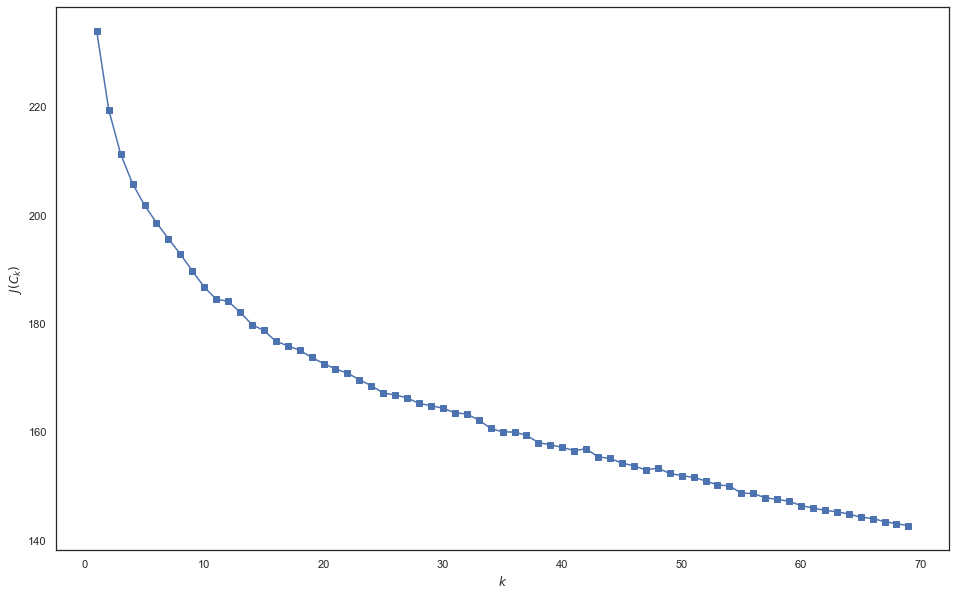

In [313]:
plt.rcParams["figure.figsize"] = (16, 10)

inertia = []
for k in range(1, 70):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_scaled.drop(['player'], axis=1))
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 70), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

**Вывод** В районе 43 лежит оптимальное кол-во кластеров, тк функционал выше уже не так сильно падает, плюс это многопользовательская игра и явно число кластеров будет много.

### Clustering's metric

Так как в текущей задаче нет хотя бы части размеченной выборки, придется воспользоваться метрикой, которая смотрит на расстояние
внутри кластеров.

Воспользуемся метрикой: Сиэлет.
        
Силуэтом выборки называется средняя величина силуэта объектов данной выборки. 
Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. 
Данная величина лежит в диапазоне $[-1, 1]$. 
Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, 
что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. 
Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.




### Develop cluster model

In [317]:
nclusters = 43

#### K-mean

In [320]:
km = KMeans(n_clusters=nclusters, random_state=seed)
km.fit(X_scaled.drop(['player'], axis=1))

# predict the cluster for each data point
y_cluster_kmeans = km.predict(X_scaled.drop(['player'], axis=1))
#y_cluster_kmeans

print("Clusters uniques: ", len(set(y_cluster_kmeans)))
print("Metric Silhouette: ", silhouette_score(X_scaled.drop(['player'], axis=1), y_cluster_kmeans))

Clusters uniques:  43
Metric Silhouette:  0.04988577787462568


#### Gaussian Mixture Model

In [321]:
# now let's try GMM clustering, which tries to fit normally-distributed clusters, 
gmm = GaussianMixture(n_components=nclusters, random_state = seed)
gmm.fit(X_scaled.drop(['player'], axis=1))

# predict the cluster for each data point
y_cluster_gmm = gmm.predict(X_scaled.drop(['player'], axis=1))
#y_cluster_gmm

print("Clusters uniques: ", len(set(y_cluster_gmm)))
print("Metric Silhouette: ", silhouette_score(X_scaled.drop(['player'], axis=1), y_cluster_gmm))

Clusters uniques:  43
Metric Silhouette:  0.049189988935843004


#### AffinityPropagation

In [322]:
aff = AffinityPropagation(random_state=seed)
aff.fit(X_scaled.drop(['player'], axis=1))

y_cluster_aff = aff.predict(X_scaled.drop(['player'], axis=1))
#y_cluster_aff
print("Clusters uniques: ", len(set(y_cluster_aff)))
print("Metric Silhouette: ", silhouette_score(X_scaled.drop(['player'], axis=1), y_cluster_aff))

Clusters uniques:  60
Metric Silhouette:  0.03879669294522188


#### DBSCAN

In [323]:
dbs = DBSCAN(eps=3, min_samples=1)
dbs.fit(X_scaled.drop(['player'], axis=1))

y_cluster_dbs = dbs.fit_predict(X_scaled.drop(['player'], axis=1))
#y_cluster_dbs

print("Clusters uniques: ", len(set(y_cluster_dbs)))
print("Metric Silhouette: ", silhouette_score(X_scaled.drop(['player'], axis=1), y_cluster_dbs))

Clusters uniques:  546
Metric Silhouette:  0.0019301872715241988


#### SpectralClustering

In [324]:
spec = SpectralClustering(n_clusters=nclusters, assign_labels='discretize', random_state=seed)

spec.fit(X_scaled.drop(['player'], axis=1))

y_cluster_spec = spec.fit_predict(X_scaled.drop(['player'], axis=1))
#y_cluster_spec

print("Clusters uniques: ", len(set(y_cluster_spec)))
print("Metric Silhouette: ", silhouette_score(X_scaled.drop(['player'], axis=1), y_cluster_spec))

Clusters uniques:  15
Metric Silhouette:  0.026215767513439157


#### AgglomerativeClustering

In [325]:
agg = AgglomerativeClustering(n_clusters=nclusters)

agg.fit(X_scaled.drop(['player'], axis=1))

y_cluster_agg = agg.fit_predict(X_scaled.drop(['player'], axis=1))
#y_cluster_agg

print("Clusters uniques: ", len(set(y_cluster_agg)))
print("Metric Silhouette: ", silhouette_score(X_scaled.drop(['player'], axis=1), y_cluster_agg))

Clusters uniques:  43
Metric Silhouette:  0.04724515197294114


#### MeanShift

In [326]:
mnsf = MeanShift(bandwidth=2)
mnsf.fit(X_scaled.drop(['player'], axis=1))

y_cluster_mnsf = agg.fit_predict(X_scaled.drop(['player'], axis=1))
#y_cluster_mnsf

print("Clusters uniques: ", len(set(y_cluster_mnsf)))
print("Metric Silhouette: ", silhouette_score(X_scaled.drop(['player'], axis=1), y_cluster_mnsf))

Clusters uniques:  43
Metric Silhouette:  0.04724515197294114


**Вывод:** Часть кластаризационных моделей сами определяют кол-во кластеров, с помощью внутреннего алгоритма
* AffinityPropagation - 60
* DBSCAN - 546
* SpectralClustering - 15

DBSCAN - явно отработал плохо, тк всех юзеров выделил в один кластер.

In [327]:
# Соберем вместе все результаты
# Forming final table with predicted clusters 


#df_fin = X_pca.copy()
df_fin = X_scaled[['player']].copy()


df_fin['Kmeans'] = y_cluster_kmeans
df_fin['GaussianMM'] = y_cluster_gmm
df_fin['AffinityPropagation'] = y_cluster_aff
df_fin['DBSCAN'] = y_cluster_dbs
df_fin['SpectralClustering'] = y_cluster_spec
df_fin['AgglomerativeClustering'] = y_cluster_agg
df_fin['MeanShift'] = y_cluster_mnsf


df_fin.head(5)

,player,Kmeans,GaussianMM,AffinityPropagation,DBSCAN,SpectralClustering,AgglomerativeClustering,MeanShift
0,player1,9,26,27,0,0,2,2
1,player2,18,15,45,1,5,42,42
2,player3,9,26,25,2,0,2,2
3,player4,4,6,43,3,3,10,10
4,player5,4,23,22,4,0,22,22


**Вывод** Для выбранной метрики, наилучшие результаты показали K-means

# 3. Vizualisation

### Сжатие данных с помощью TSNE

In [328]:
n_components = 3

In [329]:
cols_to_tsne = X_scaled.drop(['player'] , axis=1).columns

# creat TSNE and fit it
tsne = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=3)

#transform selected data
X_tsne_array = tsne.fit_transform(X[cols_to_tsne])
X_tsne = pd.DataFrame(X_tsne_array, columns=['PC1','PC2','PC3']) # PC=principal component

# Join with agent_id, this is need beacuse at end you should  player
X_tsne = pd.merge(X_scaled['player'], X_tsne, left_index=True, right_index=True)
X_tsne['Kmeans'] = y_cluster_kmeans

X_tsne.head(5)

,player,PC1,PC2,PC3
0,player1,4.028290,-12.941353,8.694479
1,player2,-15.611131,-3.810612,-9.604304
2,player3,13.265200,-2.417192,10.351788
3,player4,9.007646,-3.751533,-1.325497
4,player5,-0.992129,-5.660315,10.629865


### Визуализация TSNE данных

Text(0.5, 1.0, 'TSNE projection')

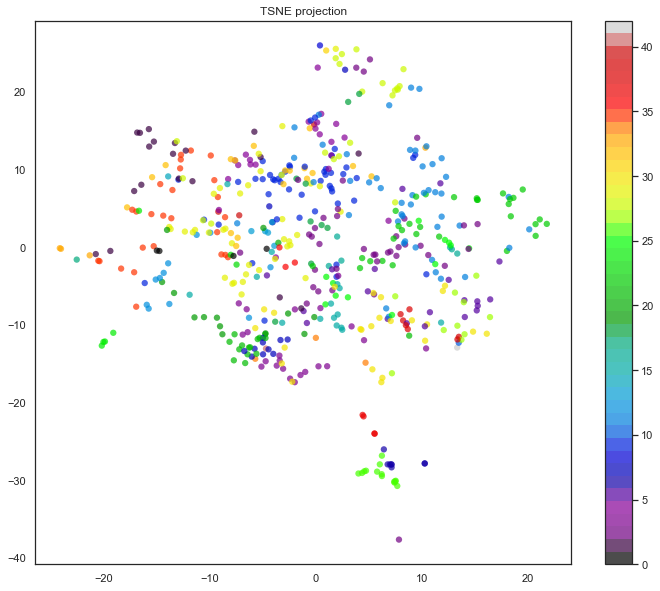

In [354]:
# Визуализируем полученный результат

plt.figure(figsize=(12,10))
plt.scatter(X_tsne['PC2'], X_tsne['PC3'], c=X_tsne['Kmeans'], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 43))
plt.colorbar()
plt.title('TSNE projection')

### 3D Визуализация TSNE данных

In [364]:

fig = px.scatter_3d(X_tsne, x='PC1', y='PC2', z='PC3',
              color='Kmeans')
fig.show()

**Вывод** В 3D реализации лучше видны кластера

### Сжатие данных с помощью PCA

#### Выбор оптимального числа компонент

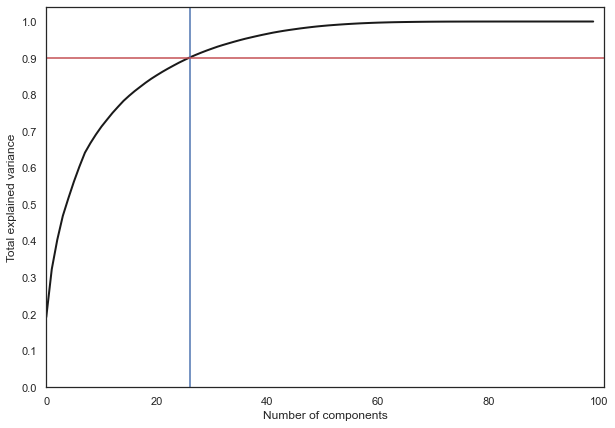

In [351]:
pca = decomposition.PCA().fit(X_scaled.drop(['player'], axis=1))

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, X_scaled.shape[1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(26, c='b')
plt.axhline(0.9, c='r')
plt.show();

**Вывод** Оптимальное кол-во компонент PCA равно 26, при таком кол-ве компонент, мы теряем всего 10% информации. <br/>
Но, чтобы сравнить с TSEN оставим три компоненты.

#### Сжатие данных

In [352]:
ndimensions = 3

# list for cols to scale
# dropo player, because it's not needed in PCA, because it is just id not data 
cols_to_pca = X_scaled.drop(['player'] , axis=1).columns

#create and fit scaler
pca = PCA(n_components=ndimensions, random_state=seed)
pca.fit(X_scaled[cols_to_pca])

#scale selected data
X_pca_array = pca.transform(X[cols_to_pca])
X_pca = pd.DataFrame(X_pca_array, columns=['PC1','PC2','PC3']) # PC=principal component

# Join with agent_id, this is need beacuse at end you should  player
X_pca = pd.merge(X_scaled['player'], X_pca, left_index=True, right_index=True)
X_pca['Kmeans'] = y_cluster_kmeans


X_pca.head(5)

,player,PC1,PC2,PC3,Kmeans
0,player1,-0.147409,4.379518,-1.713671,9
1,player2,-0.779337,-0.305775,8.837404,18
2,player3,0.036620,0.067976,-2.112690,9
3,player4,0.737385,5.795371,-1.044958,4
4,player5,-2.217083,3.040361,-3.200605,4


### 2D Визуализация PCA данных

Text(0.5, 1.0, 'PCA projection')

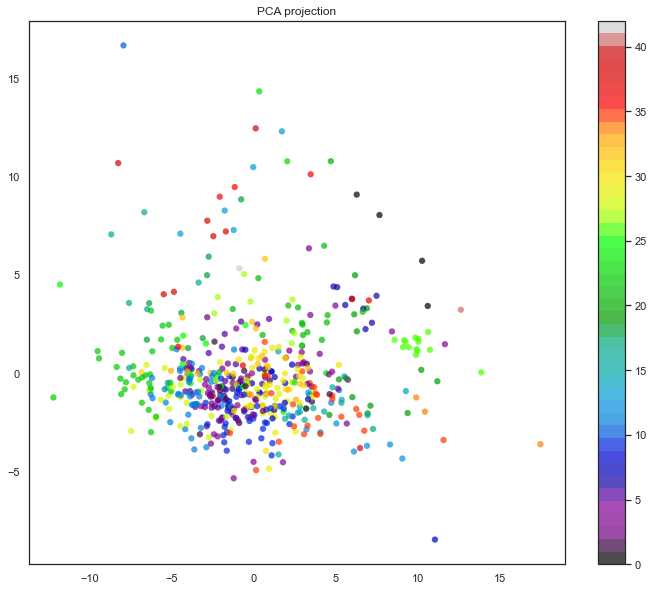

In [357]:
# Визуализируем полученный результат

plt.figure(figsize=(12,10))
plt.scatter(X_pca['PC1'], X_pca['PC3'], c=X_pca['Kmeans'], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 43))
plt.colorbar()
plt.title('PCA projection')

### 3D Визуализация PCA данных

In [363]:

fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='Kmeans')
fig.show()

**Вывод:** В PCA данные горазо хуже разбились на кластера, тк при сжатии произошла большая потеря данных около 70%

# 4. Итоговые результаты

In [361]:
X_tsne[['player', 'Kmeans']].to_csv('Task_1_answer.csv',index=False)

# 5. Что можно улучшить

Задача оценки качества кластеризации является всегда более сложной по сравнению с оценкой качества классификации. <br/>

1) **Наличием небольшого кол-ва истинных меток.**
Если бы были известны истинные метки классов, то можно было на них оценить каждый метод кластаризации и выбрать наиболее лучший.<br/>
В этом бы нам помогла метрика Adjusted Rand Index (ARI). <br/>
Если нет небольшого размеченного датасета, оценка любой кластаризации - это сложное дело. <br/>

2) **Majority voting clustering**
Возможно реализовать голосование класстаризаторов, это более сложный процесс и алгоритм, чем устраивать голосование классификаторов. <br/>

3) **Устойчивость кластаризации.**
Чтобы проверить усточивость кластаризации, можно сгенерить подвыборки с помощью бутстрепа и на каждой запустить кластаризационную <br/> модель, чтобы оценить, что класстеры полученные таким образом являются стаблиьными.